<a href="https://colab.research.google.com/github/adcroft/thin-wall-topography/blob/python/python/algorithm_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook is for developement and testing of algorithm for the thin wall topography

Some helper functions

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Helper functions

def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r',alpha=1.0):
    #mesh plot
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color, alpha=alpha)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color, alpha=alpha)
    

def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r'):
    #mesh plot
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color)

def generate_rect_test_grid(lon0,lonlen,ni,lat0,latlen,nj):
    #generate a simple rectilinear grid
    lon = lon0 + np.arange(ni+1) * lonlen/ni
    lat = lat0 + np.arange(nj+1) * latlen/nj
    lon_grid = np.tile(lon, (nj+1,1)) 
    lat_grid = np.tile(lat.reshape(nj+1,1), (1,ni+1))
    return lon_grid,lat_grid

#simple refining function. might be too slow
def refineby2(x2d):
    x_rf2 = np.zeros([x2d.shape[0]*2-1 , x2d.shape[1]*2-1])
    for j,l in enumerate(x2d):
        for i,aji in enumerate(l):
            x_rf2[2*j,2*i] = x2d[j,i]
            if(j<x2d.shape[0]-1):
                x_rf2[2*j+1,2*i] = (x2d[j,i]+x2d[j+1,i])/2
            if(i<x2d.shape[1]-1):   
                x_rf2[2*j,2*i+1] = (x2d[j,i]+x2d[j,i+1])/2
            if(j<x2d.shape[0]-1 and i<x2d.shape[1]-1):    
                x_rf2[2*j+1,2*i+2] = (x2d[j,i+1]+x2d[j+1,i+1])/2
                x_rf2[2*j+2,2*i+1] = (x2d[j+1,i]+x2d[j+1,i+1])/2
                x_rf2[2*j+1,2*i+1] = (x2d[j,i]+x2d[j,i+1]+x2d[j+1,i]+x2d[j+1,i+1])/4
    return x_rf2

def refineby2_cubic(x2d, debug=False):
    """
    Refines by cubic-interpolation (in index space)
    """
    if debug: print('x2d.shape =',x2d.shape)
    njp1,nip1 = x2d.shape # number of source nodes
    x_rf2 = np.zeros((2*njp1-1, 2*nip1-1))
    if debug: print('x_rf2.shape =',x_rf2.shape)
    
    # Fill in know values
    if debug: print('x_rf2[::2,::2].shape =',x_rf2[::2,::2].shape)
    x_rf2[::2,::2] = x2d[:,:]
    
    def cubic_fill_i(f, debug=False):
        if debug: print('f.shape =',f.shape)
        mid_val = ( f[:,2::2] + f[:,:-2:2] )/2
        if debug: print('mid_val.shape =',mid_val.shape)
        del2 = ( f[:,4::2] + f[:,:-4:2] ) - 2*f[:,2:-2:2]
        if debug: print('del2.shape =',del2.shape)
        if debug: print('f[:,3:-3:2].shape =',f[:,3:-3:2].shape)
        f[:,3:-3:2] = mid_val[:,1:-1] - ( del2[:,1:] - del2[:,:-1] )/8
        # Use mid-point on boundaries where cubic does not work
        f[:,1] = mid_val[:,0]
        f[:,-2] = mid_val[:,-1]
        return f
        
    # Cubic-interp in i-direction
    x_rf2[::2,:] = cubic_fill_i(x_rf2[::2,:], debug=debug)
    
    # Cubic-interp in j-direction (this also fills the centers)
    x_rf2 = cubic_fill_i(x_rf2.T, debug=debug).T
    
    # Alternative value for centers
    avc = cubic_fill_i(x_rf2[1::2,:], debug=debug)
    # Average two approaches for mid-point (for symmetry)
    x_rf2[1::2,1::2] = ( x_rf2[1::2,1::2] + avc[:,1::2] )/2
    
    return x_rf2

## Developing a refining algorithm

Actual source data like GEBCO (further below) are too large for devloping/tesing. Here we use simple small recitilinear grids to start with.

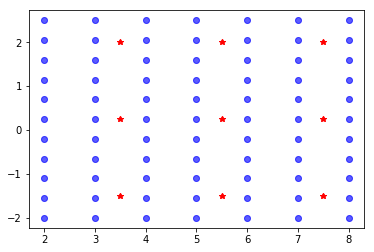

In [0]:
#Let's start with some small rectilinear grids for testing
#source grid 
src_lon_grid,src_lat_grid = generate_rect_test_grid(2,6,6,-2,4.5,10)
#print(src_lon_grid.shape,src_lat_grid.shape)
#target grid
trg_lon_grid,trg_lat_grid = generate_rect_test_grid(3.5,4,2,-1.5,3.5,2)
#print(trg_lon_grid.shape,trg_lat_grid.shape)
#plt.figure(figsize=(10,10))
plot_mesh_in_latlon(src_lon_grid, src_lat_grid, phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(trg_lon_grid, trg_lat_grid, phi_color='r*', lam_color='r*')

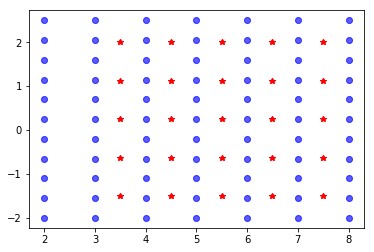

In [0]:
#refine once
lon_rf2=refineby2_cubic(trg_lon_grid)
lat_rf2=refineby2_cubic(trg_lat_grid)
#plt.figure(figsize=(10,10))
plot_mesh_in_latlon(src_lon_grid, src_lat_grid, phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(lon_rf2, lat_rf2, phi_color='r*', lam_color='r*')

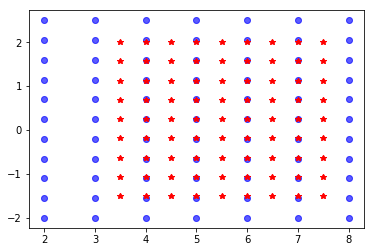

In [0]:
#refine twice
lon_rf4=refineby2(lon_rf2)
lat_rf4=refineby2(lat_rf2)
#plt.figure(figsize=(10,10))
plot_mesh_in_latlon(src_lon_grid, src_lat_grid, phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(lon_rf4, lat_rf4, phi_color='r*', lam_color='r*')


The above example shows that after two refining steps (by factors of 2) each refined cell is "smaller" than its 6 neigboring source grid cells. How do we diagnose this in general? 

Is a refined cell always surronded by 6 source cells (for any given grids)? 

Also note that in this example there are many refined grid points that are equidistant from two distinct source points which in general have different depth values. Do we average the two values in such cases? 

In [0]:
!pip install netcdf4
import netCDF4

gebcodata = netCDF4.Dataset('http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/MED_GEBCO_30sec.nc')
gebcodata

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    Conventions: CF-1.0
    title: The GEBCO_2014 Grid - a continuous terrain model for oceans and land at 30 arc-second intervals.
    institution: On behalf of the General Bathymetric Chart of the Oceans (GEBCO), the data are held at the British Oceanographic Data Centre (BODC).
    source: The bathymetric portion of the GEBCO_2014 Grid was largely developed from a database of ship track soundings with interpolation between soundings guided by satellite-derived gravity data. In areas where they improve on this existing base grid, data sets developed by other methods are included. Recognising the importance of local expertise when building a global bathymetric model, GEBCO have been working with regional mapping groups to improve the existing GEBCO grid. Details about the development of the grid and the data sets included can be found in the documentation that accompanies the data set. With t

## GEBCO  1 minute by 1 minute dataset

In [0]:
import netCDF4

gebcodata = netCDF4.Dataset('/home/niki/gfdlprojects/thin-wall-topography/work/GRIDONE_2D.nc')
#for var in gebcodata.variables :  print(var,end=' ')
#Note that the variables are arrays but they are not numpy arrays. 
#Convert them to numpy using np.array so that they can be reshaped.
gebco_lon = np.array(gebcodata.variables['lon'])
gebco_lat = np.array(gebcodata.variables['lat'])
gebco_elv = np.array(gebcodata.variables['elevation'])

gebco_lon_grd = np.tile(gebco_lon,(10801,1))
gebco_lat_grd = np.tile(gebco_lat.reshape(10801,1),(1,21601))
print('source grid array shapes: ' , gebco_lon_grd.shape,gebco_lat_grd.shape,gebco_elv.shape)
print('source grid nominal resolution : ',gebco_lon[10801]-gebco_lon[10800],gebco_lat[5401]-gebco_lat[5400] )

In [0]:
0.0166666666667 * 60

In [0]:
#Data arrays are too large to plot and my machine runs out of memory
plt.pcolormesh(gebco_lon_grd[::100,::100], gebco_lat_grd[::100,::100],gebco_elv[::100,::100]);plt.colorbar()

In [0]:
#Data arrays are too large to plot and my machine runs out of memory
plt.figure(figsize=(10,10))
plot_mesh_in_latlon(gebco_lon_grd[::1000,::1000], gebco_lat_grd[::1000,::1000], phi_color='bo', lam_color='bo')

In [0]:
#It is not clear what .zoom does, but is not doing what we want!
import scipy.ndimage
lonz = scipy.ndimage.zoom(trg_lon_grid,2,order=1)
#latz = scipy.ndimage.zoom(trg_lat_grid,2,order=1)
print (trg_lon_grid)
print (lonz)